In [1]:
!pip uninstall scikit-learn
!pip install scikit-learn==0.23.2
!pip install mne==0.24.0
!pip install mne_features==0.1

Found existing installation: scikit-learn 0.23.2
Uninstalling scikit-learn-0.23.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scikit_learn-0.23.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_learn.libs/libgomp-3300acd3.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-0.23.2
  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne

In [3]:
from mne.datasets.sleep_physionet.age import fetch_data
from mne_features.feature_extraction import extract_features
from mne.time_frequency import psd_welch

In [4]:
from scipy.stats import kurtosis
from scipy.stats import skew

In [5]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


In [6]:
def person_signal(index):
  subject = index

  [person_files] = fetch_data(subjects=[subject], recording=[1])

  mapping = {'rectal': 'misc',
            'marker': 'misc'}

  raw_train = mne.io.read_raw_edf(person_files[0])
  annot_train = mne.read_annotations(person_files[1])

  raw_train.set_annotations(annot_train, emit_warning=False)
  raw_train.set_channel_types(mapping)

  set(raw_train.get_channel_types())
  set(raw_train.annotations.description)
  raw_train.get_data().shape[1]/raw_train.info['sfreq']/60/60
  set(raw_train.ch_names)

  annotation_desc_2_event_id = {'Sleep stage W': 1,
                                'Sleep stage 1': 2,
                                'Sleep stage 2': 3,
                                'Sleep stage 3': 4,
                                'Sleep stage 4': 4,
                                'Sleep stage R': 5}

  # keep last 30-min wake events before sleep and first 30-min wake events after
  # sleep and redefine annotations on raw data
  annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                  annot_train[-2]['onset'] + 30 * 60)
  raw_train.set_annotations(annot_train, emit_warning=False)

  events_train, _ = mne.events_from_annotations(
      raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

  # create a new event_id that unifies stages 3 and 4
  event_id = {'Sleep stage W': 1,
              'Sleep stage 1': 2,
              'Sleep stage 2': 3,
              'Sleep stage 3/4': 4,
              'Sleep stage R': 5}

  tmax = 30. - 1. / raw_train.info['sfreq']
  reject_criteria = dict(
                        eeg=150e-6,       # 150 µV
                        eog=250e-6)       # 250 µV
  epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None, reject=reject_criteria)

  return epochs_train , raw_train


In [7]:
def features_extraction(signal_epochs , raw_train) :
  
  signal = signal_epochs.get_data()[:,:2,:] #  Data 714 epoch * 2 channels

  print(f'\nA) Time Domain Features: \n')

  #Stander Deviation 
  signal_std = signal.std(axis=2).flatten()
  print(f'1- Stander Deviation First Epoch  {signal_std[0]} , {signal_std[1]}')

  #Hjorth Parameters 
  selected_funcs = {'hjorth_mobility'}
  signal_hjorth_mobility = extract_features(signal, raw_train.info['sfreq'], selected_funcs).flatten()
  print(f'2- Hjorth Mobility First Epoch  {signal_hjorth_mobility[0]} , {signal_hjorth_mobility[1]}')

  selected_funcs = {'hjorth_complexity'}
  signal_hjorth_complexity = extract_features(signal, raw_train.info['sfreq'], selected_funcs).flatten()
  print(f'3- Hjorth Complexity First Epoch  {signal_hjorth_complexity[0]} , {signal_hjorth_complexity[1]}')

  #Entropy
  selected_funcs = {'app_entropy'}
  signal_entropy = extract_features(signal, raw_train.info['sfreq'], selected_funcs).flatten()
  print(f'4- Entropy First Epoch  {signal_entropy[0]} , {signal_entropy[1]}')


  print(f'\n\nB) Frequency Domain Features\n')
  #Transform To Frequency Domain
  psds, freqs = psd_welch(signal_epochs, picks='eeg', fmin=0.5, fmax=30.)

  #Kurtosis
  psd_kurtosis = kurtosis(psds , axis=2).flatten()
  print(f'\n1- Freq Kurtosis First Epoch  {psd_kurtosis[0]} , {psd_kurtosis[1]}')

  #ٍSkewness
  psd_skewness = skew(psds, axis=2).flatten()
  print(f'2- Freq Skewness First Epoch  {psd_skewness[0]} , {psd_skewness[1]}')

  #Entropy * In Frequency *
  selected_funcs = {'spect_entropy'}
  psd_entropy = extract_features(psds, raw_train.info['sfreq'], selected_funcs).flatten()
  print(f'3- Freq Entropy First Epoch  {psd_entropy[0]} , {psd_entropy[1]}')

  #Spectral Centroid
  psd_spectral_centroid = ((psds*freqs).sum(-1)/psds.sum(-1)).flatten()
  print(f'4- Freq Spectral Centroid First Epoch  {psd_spectral_centroid[0]} , {psd_spectral_centroid[1]}')

  features = np.transpose(
      [signal_std, signal_hjorth_mobility , signal_hjorth_complexity , signal_entropy , psd_kurtosis , psd_skewness , psd_entropy , psd_spectral_centroid]
      )
  
  return features 

    

In [8]:
def duplicate_labels(labels):
  return np.repeat(labels, 2)

In [9]:
def preprocessing(signal_epochs , raw_train):

  features = features_extraction(signal_epochs , raw_train) # Features 1428 * 8 

  labels = signal_epochs.events[:,2] # Labels 714 
  labels = duplicate_labels(labels) # labels 1428 => Because We Flatten The 2 Channels
  
  return features , labels


### Create The Train Data

In [10]:
X_train = np.empty((0,8), np.float64)
y_train = np.array([], dtype=int)

for i in range(16):
  print(f'\n\nPerson {i+1}')
  person , raw_train= person_signal(i)
  person_features , person_labels = preprocessing(person , raw_train)
  X_train = np.append(X_train, person_features, axis=0) 
  y_train = np.append(y_train, person_labels, axis=0) 
  print(f'\n\n==============\n')
  

Streaming output truncated to the last 5000 lines.
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz', 'Pz-Oz']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EEG : ['

In [11]:
print(X_train.shape)
print(y_train.shape)

(16222, 8)
(16222,)


### Create The Test


In [12]:
X_test = np.empty((0,8), np.float64)
y_test = np.array([], dtype=int)

for i in range(16 , 21):
  print(f'\n\nPerson {i+1}')
  person , raw_train = person_signal(i)
  person_features , person_labels = preprocessing(person , raw_train)
  X_test = np.append(X_test, person_features, axis=0) 
  y_test = np.append(y_test, person_labels, axis=0) 
  print(f'\n\n==============\n')
  



Person 17
Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4161E0-PSG.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
rectal, marker
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1144 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1144 events and 3000 original time points ...
    Rejecting  epoch based on EEG : ['Fpz-Cz', 'Pz-Oz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz', 'Pz-Oz']
    Rejecting  epoch based on EEG : ['Fpz-Cz', 'Pz-Oz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz', 'Pz-Oz']
    Rejecting  ep

In [13]:
print(X_test.shape)
print(y_test.shape)

(5962, 8)
(5962,)


In [14]:
features_names = ['Time STD', 'Time Hjorth Mobility' , 'Time Hjorth Complexity' , 'Time Entropy', 'Freq Kurtosis' , 'Freq Skewness' , 'Freq Entropy' , 'Freq Sectrl Centroid']


## SVM Model

In [15]:
svm = SVC(kernel='linear')

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)


print("SVM Accuracy: ",metrics.accuracy_score(y_test, y_pred))

print("SVM Precision Score: ",metrics.precision_score(y_test, y_pred,
                                          average='macro'))

print("SVM Recall Score: ",metrics.recall_score(y_test, y_pred, 
                                           average='macro'))

SVM Accuracy:  0.643240523314324
SVM Precision Score:  0.4964863085379463
SVM Recall Score:  0.2929982311020954


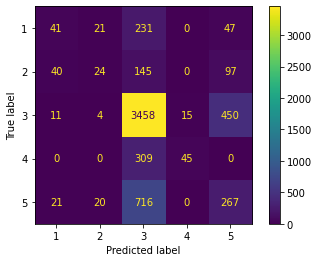

In [16]:
plot_confusion_matrix(svm, X_test, y_test)  
plt.show()

### SVM Features Importances

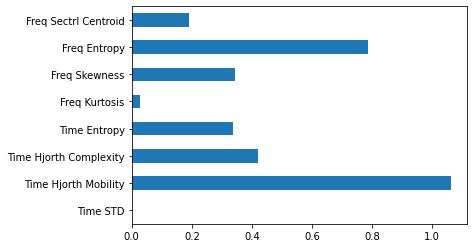

In [17]:
pd.Series(abs(svm.coef_[0]), index=features_names).plot(kind='barh')


# KNN Model

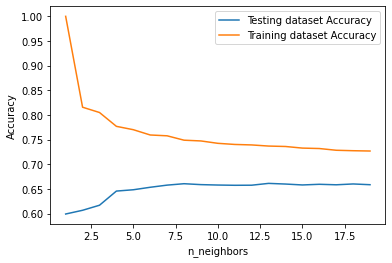


The Best N Neighbors Is: 12

KNN Accuracy:  0.6578329419657833
KNN Precision Score:  0.47311657008179236
KNN Recall Score:  0.30234465724208787


In [18]:
neighbors = np.arange(1, 20)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
 
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
 
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

best_n_neighbors = np.argmax(test_accuracy)
print(f'\nThe Best N Neighbors Is: {best_n_neighbors}\n')

knn = KNeighborsClassifier( n_neighbors= best_n_neighbors )
 
knn.fit(X_train, y_train)
 
# Predict on dataset which model has not seen before
y_pred = knn.predict(X_test)

print("KNN Accuracy: ",metrics.accuracy_score(y_test, y_pred))

print("KNN Precision Score: ",metrics.precision_score(y_test, y_pred, 
                                           average='macro'))

print("KNN Recall Score: ",metrics.recall_score(y_test, y_pred, 
                                           average='macro'))

# Random Forest Model

In [19]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Random Fores Accuracy: ",metrics.accuracy_score(y_test, y_pred))

print("Random Fores Precision Score: ",metrics.precision_score(y_test, y_pred, 
                                           average='macro'))

print("Random Fores Recall Score: ",metrics.recall_score(y_test, y_pred, 
                                           average='macro'))

Random Fores Accuracy:  0.6717544448171754
Random Fores Precision Score:  0.49926625474522063
Random Fores Recall Score:  0.36870571454176915


#### Random Forest Features Importances


Feature: 0, Score: 0.11851
Feature: 1, Score: 0.13347
Feature: 2, Score: 0.11954
Feature: 3, Score: 0.15756
Feature: 4, Score: 0.08681
Feature: 5, Score: 0.08945
Feature: 6, Score: 0.13797
Feature: 7, Score: 0.15670


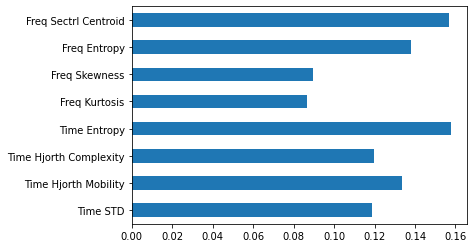

In [20]:
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
pd.Series(importance, index=features_names).plot(kind='barh')


# Decision Tree Model

In [21]:

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, y_train)

y_pred=decision_tree.predict(X_test)

print("Decision Tree Accuracy: ",metrics.accuracy_score(y_test, y_pred))

print("Decision Tree Precision Score: ",metrics.precision_score(y_test, y_pred, 
                                           average='macro'))

print("Decision Tree Recall Score: ",metrics.recall_score(y_test, y_pred, 
                                           average='macro'))


Decision Tree Accuracy:  0.5934250251593425
Decision Tree Precision Score:  0.3835088160886599
Decision Tree Recall Score:  0.3747448336596778


#### Decision Tree Features Importances

Feature: 0, Score: 0.12368
Feature: 1, Score: 0.10718
Feature: 2, Score: 0.11881
Feature: 3, Score: 0.18082
Feature: 4, Score: 0.07499
Feature: 5, Score: 0.06730
Feature: 6, Score: 0.13909
Feature: 7, Score: 0.18813


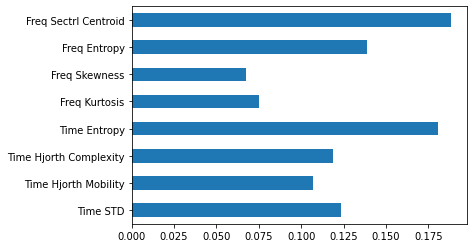

In [22]:
# get importance
importance = decision_tree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pd.Series(importance, index=features_names).plot(kind='barh')
